# Transformers for tabular data. Categorical Encoder

Inspired and based on https://github.com/s-nlp/transformers-course/blob/main/Seminars/15_Tabular_Transformer.ipynb

In [1]:
from typing import List, Tuple
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

In [2]:
import warnings
# Suppress all user warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(42)

X, y = fetch_openml("Bank_marketing_data_set_UCI", version=1, as_frame=True, return_X_y=True)
data = X.join(y)
del X, y
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign',
       'previous', 'poutcome']

num_cols = ['age', 'balance', 'duration', 'pdays']
target=["y"]

In [5]:
train, test = train_test_split(data, stratify=data["y"], test_size=0.2, random_state=42)

# LightGBM

In [6]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

# LightGBM needs categorical columns encoded as integers
train_enc = train.copy()
test_enc = test.copy()
for col in cat_cols:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", encoded_missing_value=np.nan, unknown_value=np.nan)
    train_enc[col] = enc.fit_transform(train_enc[col].values.reshape(-1,1))
    test_enc[col] = enc.transform(test_enc[col].values.reshape(-1,1))

In [7]:
clf = LGBMClassifier(random_state=42)
clf.fit(train_enc.drop(columns=target[0]), train_enc[target], categorical_feature=cat_cols)
test_pred = clf.predict(test_enc.drop(columns=target[0]))
test_pred_proba = clf.predict_proba(test_enc.drop(columns=target[0]))

acc = accuracy_score(test[target[0]].values, test_pred)
loss = log_loss(test[target[0]].values, test_pred_proba)
print(f"Acc: {acc} | LogLoss: {loss}")

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
Acc: 0.9083268826716797 | LogLoss: 0.19783125832611875


# Transformers

In [8]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import (
    CategoryEmbeddingModelConfig,
    FTTransformerConfig,
    TabNetModelConfig,
    GatedAdditiveTreeEnsembleConfig,
    TabTransformerConfig,
    AutoIntConfig
)
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig

In [9]:
data_config = DataConfig(
    target=target, #target should always be a list.
    continuous_cols=num_cols,
    categorical_cols=cat_cols,
)

for col in data_config.continuous_cols:
    train[col] = train[col].astype("float64")
    test[col] = test[col].astype("float64")

trainer_config = TrainerConfig(
#     auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=256,
    max_epochs=500,
    early_stopping="valid_loss", # Monitor valid_loss for early stopping
    early_stopping_mode = "min", # Set the mode as min because for val_loss, lower is better
    early_stopping_patience=5, # No. of epochs of degradation training will wait before terminating
    checkpoints="valid_loss", # Save best checkpoint monitoring val_loss
    load_best=True, # After training, load the best checkpoint
)

optimizer_config = OptimizerConfig()

head_config = LinearHeadConfig(
    layers="", # No additional layer in head, just a mapping layer to output_dim
    dropout=0.1,
    initialization="kaiming"
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

## Category Embeddings

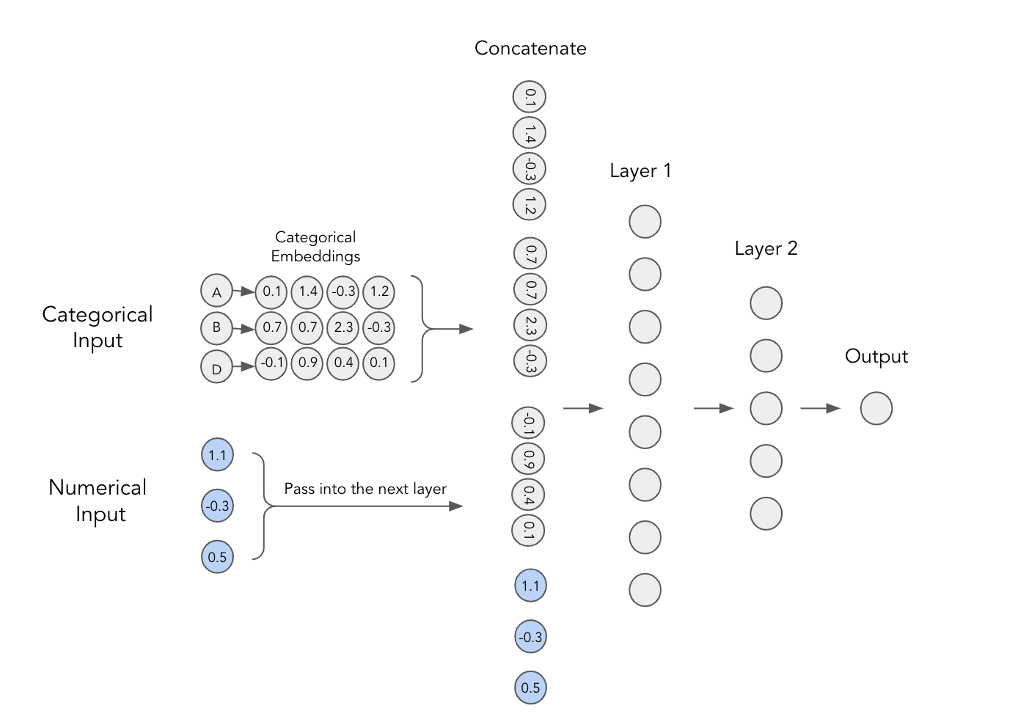

In [10]:
model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="64-32",  # Number of nodes in each layer
    activation="ReLU", # Activation between each layers
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train)
tabular_model.evaluate(test)

2025-03-02 00:00:27,226 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-03-02 00:00:27,252 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-03-02 00:00:27,368 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-03-02 00:00:27,574 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: CategoryEmbeddingModel

2025-03-02 00:00:27,615 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-03-02 00:00:27,646 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                      ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ CategoryEmbeddingBackbone │  8.2 K │ train │
│ 1 │ _embedding_layer │ Embedding1dLayer          │  2.7 K │ train │
│ 2 │ head             │ LinearHead                │     66 │ train │
│ 3 │ loss             │ CrossEntropyLoss          │      0 │ train │
└───┴──────────────────┴───────────────────────────┴────────┴───────┘

Trainable params: 10.9 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 10.9 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 26                                                                                          
Modules in eval mode: 0

Output()

2025-03-02 00:00:49,243 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-03-02 00:00:49,244 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9018024802207947     │
│         test_loss         │    0.22049854695796967    │
│        test_loss_0        │    0.22049854695796967    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_0': 0.22049854695796967,
  'test_loss': 0.22049854695796967,
  'test_accuracy': 0.9018024802207947}]

In [89]:
num_cols

['age', 'balance', 'duration', 'pdays']

### Vanilla

In [11]:
# encode target for convenience
train_enc[target[0]] = train_enc[target[0]].map({'yes': 1, 'no': 0})
test_enc[target[0]] = test_enc[target[0]].map({'yes': 1, 'no': 0})

In [12]:
# check the arhitecture of the torch_tabular model
tabular_model.model

CategoryEmbeddingModel(
  (_backbone): CategoryEmbeddingBackbone(
    (linear_layers): Sequential(
      (0): Linear(in_features=94, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
    )
  )
  (_embedding_layer): Embedding1dLayer(
    (cat_embedding_layers): ModuleList(
      (0): Embedding(13, 7)
      (1): Embedding(4, 2)
      (2): Embedding(5, 3)
      (3-5): 3 x Embedding(3, 2)
      (6): Embedding(4, 2)
      (7): Embedding(32, 16)
      (8): Embedding(13, 7)
      (9): Embedding(47, 24)
      (10): Embedding(39, 20)
      (11): Embedding(5, 3)
    )
    (normalizing_batch_norm): BatchNorm1d(
      (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (head): LinearHead(
    (layers): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
    )
  )
  (loss): CrossEntropyLoss()
)

In [13]:
# unique categories for each feature
train_enc[cat_cols].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
day          31
month        12
campaign     47
previous     41
poutcome      4
dtype: int64

In [90]:
config = {
    "train_data_path": "data/train.csv",
    "val_data_path": "data/val.csv",
    "cat_cols": ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day',
 'month',
 'campaign',
 'previous',
 'poutcome'],
    "num_cols": ['age', 'balance', 'duration', 'pdays'],
    "target": "y",
    "batch_size": 256,
    "lr": 1e-3,
    "n_epochs": 100,
    "patience": 5,
    "best_model_path": "best_model.pth"
}

In [14]:
categorical_cardinality = []
for col in cat_cols:
    categorical_cardinality.append(train_enc[col].nunique() + 1)

# to fix embedding dims as it is done in torch_tabular
embedding_dims = [(x, min(50, (x + 1) // 2)) for x in categorical_cardinality]
embedding_dims

[(13, 7),
 (4, 2),
 (5, 3),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (32, 16),
 (13, 7),
 (48, 24),
 (42, 21),
 (5, 3)]

In [15]:
len(num_cols) + sum(dim[1] for dim in embedding_dims)  # input size

95

In [16]:
len(embedding_dims)

12

In [17]:
emb = nn.Embedding(12, 4)

In [18]:
emb(torch.tensor([0, 0, 11, 3]))

tensor([[ 0.4536, -1.4628,  1.3201,  0.7185],
        [ 0.4536, -1.4628,  1.3201,  0.7185],
        [-1.0089, -0.0432,  0.1454, -0.4854],
        [ 0.3683,  0.2877, -0.5607, -1.2908]], grad_fn=<EmbeddingBackward0>)

In [19]:
emb.weight

Parameter containing:
tensor([[ 0.4536, -1.4628,  1.3201,  0.7185],
        [ 0.4214, -0.4842, -1.4783,  0.5300],
        [-0.6308,  0.7035, -1.0806, -0.1798],
        [ 0.3683,  0.2877, -0.5607, -1.2908],
        [-0.2175, -0.0043, -0.7377, -1.5626],
        [ 0.0980,  2.1202,  1.1259, -1.0247],
        [ 0.2528, -1.5918,  1.0044,  1.2693],
        [ 0.3604, -0.4787, -1.6672, -0.5533],
        [ 0.6527, -0.3517,  1.8621,  0.9831],
        [ 1.0695,  1.5290,  0.3095,  0.7432],
        [-1.0584,  0.5222, -1.0489,  1.2348],
        [-1.0089, -0.0432,  0.1454, -0.4854]], requires_grad=True)

In [20]:
class CategoryDataset(Dataset):
    def __init__(self, data: pd.DataFrame, cat_cols: List[str], num_cols: List[str], target_col: List[str]) -> None:
        """
        Categorical features should be encoded
        """
        self.data = data
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.target_col = target_col

        self.cat_data = self.data[self.cat_cols].values
        self.num_data = self.data[self.num_cols].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Return categorical data, numerical data and target
        """
        x_cat = self.cat_data[index]
        x_num = self.num_data[index]
        y = self.data[self.target_col].values[index]

        return torch.tensor(x_cat, dtype=torch.int64), torch.tensor(x_num, dtype=torch.float32), torch.tensor(y, dtype=torch.int64)

In [21]:
cat_dataset = CategoryDataset(train_enc, cat_cols=cat_cols, num_cols=num_cols, target_col=target)

In [22]:
cat_dataset[0:3][0][:, 0]

tensor([9, 8, 9])

In [23]:
train_enc.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24001,36,9.0,0.0,1.0,0.0,861,0.0,0.0,1.0,28.0,1.0,140,1.0,-1,0.0,3.0,0
43409,24,8.0,2.0,1.0,0.0,4126,0.0,0.0,0.0,4.0,0.0,907,3.0,185,7.0,0.0,1
20669,44,9.0,2.0,1.0,0.0,244,1.0,0.0,0.0,11.0,1.0,1735,3.0,-1,0.0,3.0,1


In [75]:
class CategoryEmbeddingModel(nn.Module):
    def __init__(self, embedding_dims, n_num_cols):
        super().__init__()
        self.category_embeddings = nn.ModuleList([nn.Embedding(x, y) for x, y in embedding_dims])  # embedding for each categorical feature

        in_features = n_num_cols + sum(dim[1] for dim in embedding_dims)
        self.n_cat_cols = len(embedding_dims)
        self.n_num_cols = n_num_cols
        
        self.backbone = nn.Sequential(*[
            nn.Linear(in_features, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 32, bias=True),
            nn.ReLU()
        ])

        self.normalizing_batch_norm = nn.BatchNorm1d(n_num_cols)

        self.head = nn.Sequential(*[
            nn.Linear(32, 2, bias=True)
        ])

        cat_num_categories = torch.tensor([dim[0] for dim in embedding_dims], dtype=torch.int64)
        self.register_buffer("cat_num_categories", cat_num_categories)

        # init weights
        for layer in self.backbone:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        for layer in self.head:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x_cat, x_num):
        # work-around unknown categories
        x_cat += 1  # 0 is <UNKNOWN>
        expanded_categories = self.cat_num_categories.unsqueeze(0).expand(x_cat.size(0), -1)  # [batch_size, num_cat_features]
        x_cat = torch.where(x_cat < expanded_categories, x_cat, 0)
        
        # x_cat += 1  # 0 is <UNKNOWN>
        # mask = x_cat < self.cat_num_categories
        # x_cat = x_cat * mask
        
        # encode each categorical
        x_cat_encoded = [self.category_embeddings[i](x_cat[:, i]) for i in range(self.n_cat_cols)]

        # concatenate output from each categorical embedder
        x_cat_encoded = torch.cat(x_cat_encoded, dim=1)

        # preprocess num_features with normalizing
        x_num_encoded = self.normalizing_batch_norm(x_num)

        # concatenate categorical and numarical
        x = torch.cat([x_cat_encoded, x_num_encoded], dim=1)

        # pass to the mlp
        x = self.backbone(x)
        x = self.head(x)
        return x

In [76]:
cat_model = CategoryEmbeddingModel(embedding_dims=embedding_dims, n_num_cols=len(num_cols))

In [77]:
sample = cat_dataset[0:3]
out = cat_model(sample[0], sample[1])
print(out)

tensor([[-0.4004, -0.9542],
        [ 0.1432,  0.6471],
        [ 0.4445, -0.4598]], grad_fn=<AddmmBackward0>)


In [27]:
train_set, val_set = train_test_split(train_enc, stratify=train_enc["y"], test_size=0.2, random_state=42)

In [28]:
categorical_cardinality = []
for col in cat_cols:
    categorical_cardinality.append(train_set[col].nunique() + 1)

# to fix embedding dims as it is done in torch_tabular
embedding_dims = [(x, min(50, (x + 1) // 2)) for x in categorical_cardinality]
embedding_dims

[(13, 7),
 (4, 2),
 (5, 3),
 (3, 2),
 (3, 2),
 (3, 2),
 (4, 2),
 (32, 16),
 (13, 7),
 (47, 24),
 (41, 21),
 (5, 3)]

In [84]:
# train model
device = "cuda" if torch.cuda.is_available() else 'cpu'

batch_size = 256
lr = 1e-3

cat_model = CategoryEmbeddingModel(embedding_dims=embedding_dims, n_num_cols=len(num_cols)).to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cat_model.parameters(), lr=lr)

train_dataset = CategoryDataset(train_set, cat_cols=cat_cols, num_cols=num_cols, target_col=target)
val_dataset = CategoryDataset(val_set, cat_cols=cat_cols, num_cols=num_cols, target_col=target)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [82]:
def evaluate(model, dataloader, loss_fn):
    model.eval()  # Переводим модель в режим оценки
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Отключаем вычисление градиентов
        for x_cat, x_num, y in dataloader:
            x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)
            y_pred = model(x_cat, x_num)  # Получаем logits

            # Вычисляем loss
            batch_loss = loss_fn(y_pred, y.squeeze())
            total_loss += batch_loss.item() * y.size(0)

            # Вычисляем accuracy
            _, predicted = torch.max(y_pred, 1)  # Получаем предсказанные классы
            total_correct += (predicted.squeeze() == y.squeeze()).sum().item()  # Считаем количество правильных предсказаний
            total_samples += y.size(0)  # Общее количество примеров

    # Средний loss и accuracy
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

In [85]:
# Оценка модели до обучения
val_loss, val_accuracy = evaluate(cat_model, val_dataloader, loss)
print(f'Untrained model scores:\nloss: {val_loss}\naccuracy: {val_accuracy}')

# Обучение модели
patience = 5  # Сколько эпох ждать улучшения val_loss
best_val_loss = float("inf")  # Лучший val_loss
epochs_without_improvement = 0  # Счетчик эпох без улучшения
best_model_path = "best_model.pth"  # Путь для сохранения лучшей модели

N_EPOCHS = 100

for epoch in range(N_EPOCHS):
    cat_model.train()
    train_losses = []
    start_time = time.time()

    # Обучение на train_dataloader
    for x_cat, x_num, y in train_dataloader:
        optimizer.zero_grad()

        x_cat, x_num, y = x_cat.to(device), x_num.to(device), y.to(device)

        y_pred = cat_model(x_cat, x_num)
        batch_loss = loss(y_pred, y.squeeze())
        train_losses.append(batch_loss.item())

        batch_loss.backward()
        optimizer.step()

    # Оценка на val_dataloader
    val_loss, val_accuracy = evaluate(cat_model, val_dataloader, loss)
    print(f"Epoch: {epoch + 1}. Train loss: {np.mean(train_losses)}. Val loss: {val_loss}. Val accuracy: {val_accuracy}")

    # Ранняя остановка и сохранение лучшей модели
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(cat_model.state_dict(), best_model_path)  # Сохраняем веса лучшей модели
        print(f"New best model saved with val_loss: {best_val_loss}")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epochs")

    # Прекращаем обучение, если val_loss не улучшается в течение patience эпох
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Загрузка лучшей модели
cat_model.load_state_dict(torch.load(best_model_path))
print("Training complete. Best model loaded.")

Untrained model scores:
loss: 73.87603135724605
accuracy: 0.8501520597179983
Epoch: 1. Train loss: 0.31675560739740993. Val loss: 0.2536469258950961. Val accuracy: 0.8968758639756704
New best model saved with val_loss: 0.2536469258950961
Epoch: 2. Train loss: 0.24063782642285028. Val loss: 0.24109656590106313. Val accuracy: 0.8995023500138236
New best model saved with val_loss: 0.24109656590106313
Epoch: 3. Train loss: 0.22787399224021979. Val loss: 0.2315535154713759. Val accuracy: 0.8983964611556539
New best model saved with val_loss: 0.2315535154713759
Epoch: 4. Train loss: 0.21969594165944217. Val loss: 0.22595425050232928. Val accuracy: 0.9008847110865358
New best model saved with val_loss: 0.22595425050232928
Epoch: 5. Train loss: 0.21329594383898534. Val loss: 0.2219634360211773. Val accuracy: 0.8979817528338402
New best model saved with val_loss: 0.2219634360211773
Epoch: 6. Train loss: 0.21076987919054532. Val loss: 0.22116030684682852. Val accuracy: 0.9021288360519768
New bes